In [1]:
# import torch
# torch.cuda.is_available()
# We first import all the packages we will need for the project

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set_style('white')
plt.set_cmap('gist_gray')


# We also install a package to read NiFTI files
import nibabel as nib
import torch
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# We open the demographics table using the pandas package (pd)
df = pd.read_csv('./demographics.csv')
# We display the 10 first lines
subjects_id = []
missing_subjects = []
#figure out the subject ids of the invalid scans
for i in df.path_process_data[0:563]:
    subject_num = int(i[3:6])
    subjects_id.append(subject_num)
for j in range(663):
    if j not in subjects_id:
        missing_subjects.append(j)
# print(missing_subjects)

There are 1597 patients
There are 25 hospitals
There are 2 datasets
There are 55.48% of women
Age statistics : 
count    1597.000000
mean       35.599132
std        17.491271
min        18.000000
25%        22.000000
50%        27.000000
75%        48.052019
max        86.318960
Name: age, dtype: float64


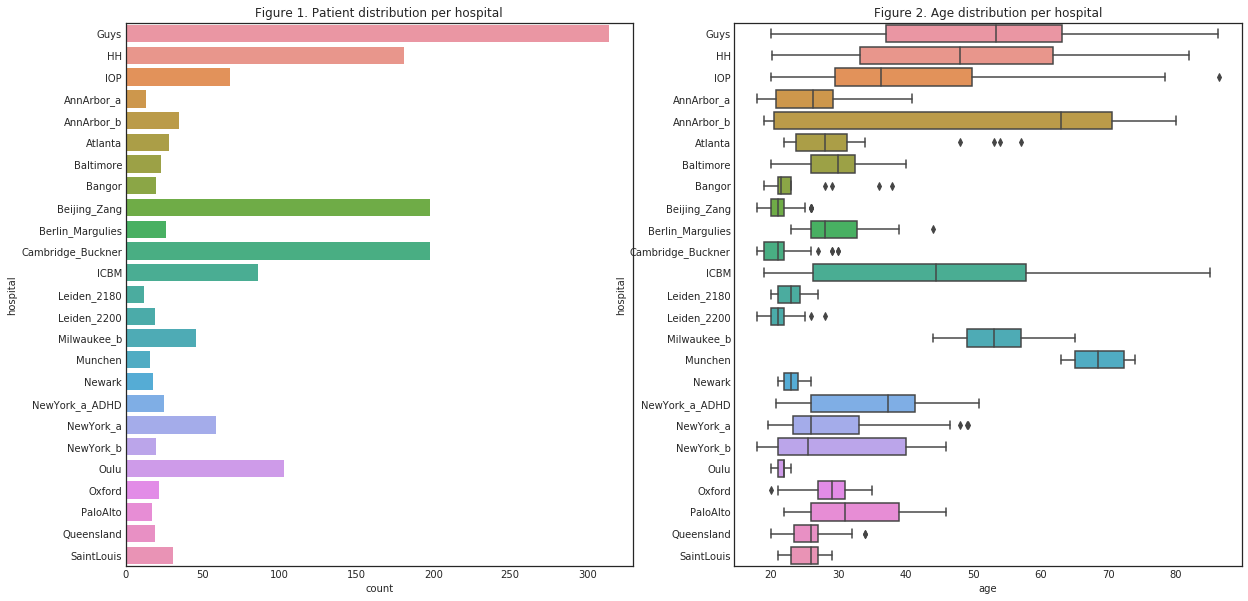

In [3]:
# We can use the packages matplotlib (plt) and seaborn (sns) to plot figures
# Figure 1 shows that patients are not equally distributed across hospitals
# Figure 2 shows that ages     are not equally distributed across hospitals

# We first print some statistics
print('There are {} patients'.format(len(df)))
print('There are {} hospitals'.format(len(df.hospital.unique())))
print('There are {} datasets'.format(len(df.dataset.unique())))
print('There are {:.2f}% of women'.format(100*np.mean(df.sex == 'f')))
print('Age statistics : ')
print(df.age.describe())

# We plot the patient count over hospitals
plt.figure(figsize=(20,10)) 
plt.subplot(121) 
sns.countplot(y='hospital', data=df)
plt.title('Figure 1. Patient distribution per hospital')

# We plot the age distribution over hospitals
plt.subplot(122)
sns.boxplot(x='age', y='hospital', data=df)
plt.title('Figure 2. Age distribution per hospital');

In [5]:
# In this cell, we plot one slice of the MRI of a subject

# We first load the 2 files associated to raw data and segmentation
import os
from IPython.display import clear_output

df = pd.read_csv('../BrainAge/demographics.csv')

#Collect all pre-processed images from .anat directories
skullstripped_img_list = []
ori_img_list = []
seg_img_list = []
file_id = []
sample_size = 0
root_path = "/shared/ixi-dataset/"
for i in range(19):
    dir_name = root_path + "IXI-T1-" + str(i)
    anat_directories = [x for x in os.listdir(dir_name) if x.endswith('.anat')]
    for anat_directory in anat_directories:
        ori_file_name = dir_name + '/' + anat_directory + '/T1_biascorr.nii.gz'
        seg_file_name = dir_name + '/' + anat_directory + "/T1_fast_seg.nii.gz"
        if anat_directory[0:3] == 'IXI' and os.path.exists(ori_file_name) and os.path.exists(seg_file_name):
            ori_img = nib.load(ori_file_name).get_data()
            seg_img = nib.load(seg_file_name).get_data()
            skullstripped_img = ori_img * (seg_img > 0)
            ori_img_list.append(ori_img)
            seg_img_list.append(seg_img)
            skullstripped_img = (skullstripped_img - np.mean(skullstripped_img)) / np.std(skullstripped_img)
            skullstripped_img_list.append(skullstripped_img)
            file_id.append(anat_directory[3:6])
            sample_size += 1
            clear_output(wait=True)
            #print(sample_size)
print(len(file_id))
print(len(skullstripped_img_list))

536
536


Shape of the MRI : (256, 181, 150)


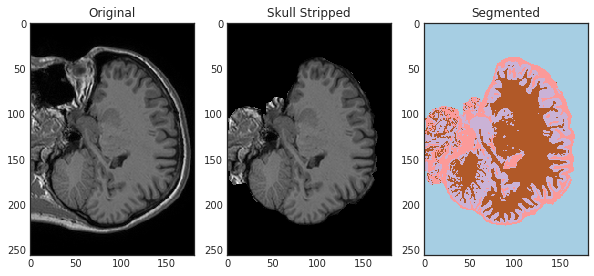

In [6]:
#Validate the sample
dimension = 2
s = 90
sample = 5

plt.figure(figsize=(10, 5))
print('Shape of the MRI : {}'.format(ori_img_list[sample].shape))
plt.subplot(131)
plt.imshow(np.take(ori_img_list[sample], s, dimension))
plt.title('Original');

plt.subplot(132)
plt.imshow(np.take(skullstripped_img_list[sample], s, dimension))
plt.title('Skull Stripped');

plt.subplot(133)
plt.imshow(np.take(seg_img_list[sample], s, dimension), cmap='Paired')
plt.title('Segmented');

([array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         2.53105114e-03, 2.18895901e-02, 3.86578514

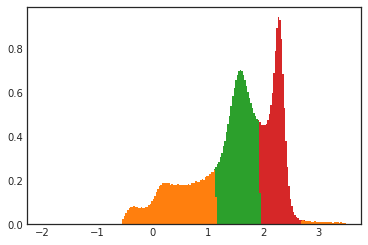

In [6]:
plt.hist(skullstripped_img_list[sample][seg_img_list[sample] > 0], range=(-2,3.5),bins=200, density=True)
plt.hist([skullstripped_img_list[sample][seg_img_list[sample] == i] for i in [1, 2, 3]], range=(-2,3.5),stacked=True,bins=200, density=True)
 

In [28]:
#Filter the csv file with only IXI filenames
sheet = df.values
filtered = list()
for i in range(0, len(sheet)):
    if sheet[i, 5][0:3] == 'IXI':
        filtered.append((sheet[i, 5], sheet[i, 4]))
sheet = filtered

#Create the labels for the skullstripped images
age = list()
for i in range(0, len(file_id)):
    for patient in sheet:
        if patient[0][3:6] == file_id[i]:
            age.append(patient[1])

onehot_age = list()
for i in range(0, len(age)):
    current_age = int(round(age[i]))
    current_age -= 18
    one_hot = [0 for i in range(13)]
    if current_age >= 60:
        one_hot[-1] = 1
    else:
        one_hot[current_age // 5] = 1
    onehot_age.append(one_hot)
print(len(onehot_age))


536


In [31]:
#Saves the tensor


# age = torch.from_numpy(np.asarray(age))
# torch.save(age,"ages.pt")
ages = torch.load("ages.pt")
print(ages.shape)

# age_class = torch.from_numpy(np.asarray(np.argmax(onehot_age,axis=1)))
# torch.save(age_class,"labels_1.pt")
age_class = torch.load("labels_1.pt")
print(age_class.shape)

# onehot_age = torch.from_numpy(np.asarray(onehot_age))
# torch.save(onehot_age,"labels_13.pt")
labels = torch.load("labels_13.pt")
print(labels.shape)

torch.Size([536])
torch.Size([536])
torch.Size([536, 13])


In [8]:
#Next we compute the histogram
histograms = np.empty((len(skullstripped_img_list), 200))
        
for i in range(0, len(skullstripped_img_list)):
    histogram = skullstripped_img_list[i][seg_img_list[i] > 0]
    histograms[i], _ = np.histogram(np.ravel(histogram), bins=200, density=True)

In [9]:
#Next we normalize the vector for better prediction
# ready_made_histogram = np.load('../BrainAge/histograms.npy')
# print(np.mean(ready_made_histogram[512]))
# print(np.std(ready_made_histogram[512]))
# means = np.mean(histograms, axis=1, keepdims=True)
# std = np.std(histograms, axis=1, keepdims=True)

# histograms = histograms - means + 5/9
# histograms = histograms / std * 0.684
# print(np.mean(histograms[512]))
# print(np.std(histograms[512]))

In [10]:
#Some other sanity-check to make sure that input and label and properly aligned
X = histograms
Y = np.array(age)
# print(file_id)
# print(age)
# df.head(590)

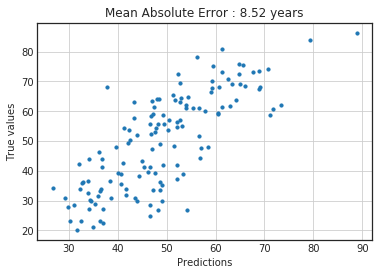

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV

# We create a function to train and test a linear model

def train_linear_regression(train, test):
    # Create model
    model = RidgeCV()

    # Train on the training set : fit the models with pairs (X, Y)
    model.fit(X[train], Y[train])

    # Predict on the test set
    predictions = model.predict(X[test])
    true_values = Y[test]
    
    # Plot the results and compute the MAE
    plt.scatter(predictions, true_values, s=10)
    plt.grid()
    plt.xlabel('Predictions')
    plt.ylabel('True values')
    mae = np.mean(np.abs(predictions - true_values))
    plt.title('Mean Absolute Error : {:.2f} years'.format(mae))
    plt.show()


# We don't perform 5 fold cross validation here, but a single split

# 1. Random split
# We randomly split the data between train and test with 80/20 proportions
train, test = train_test_split(np.arange(sample_size), test_size=0.25,
                              random_state=0)
# print('Random Split')
# print('Size of the test set : {} patients'.format(len(test)))
# We use our function on this split
train_linear_regression(train, test)

# 2. Hospital split
# We split the hospitals using Guys hospital as the test set
# train = np.where(df.hospital != 'Guys')[0]
# test = np.where(df.hospital == 'Guys')[0]
# print('Hospital Split')
# print('Size of the test set : {} patients'.format(len(test)))
# train_linear_regression(train, test)

tensor(281.9251, grad_fn=<MseLossBackward>)


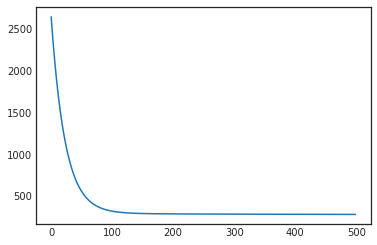

In [36]:
import torch 
from torch.autograd import Variable 
  
class LinearRegressionModel(torch.nn.Module): 
  
    def __init__(self): 
        super(LinearRegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(200, 1)
  
    def forward(self, x): 
        y_pred = self.linear(x) 
        return y_pred 
  
model = LinearRegressionModel() 
  
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001) 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.1, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.1, amsgrad=False)

X = X.astype('float32')
Y = Y.astype('float32')

loss_hist = []
for epoch in range(500): 
  
    # Forward pass: Compute predicted y by passing  
    # x to the model
    inputs = Variable(torch.from_numpy(X))
    labels = Variable(torch.from_numpy(Y))
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss_hist.append(loss)
    optimizer.zero_grad() 
    
    loss.backward() # back props
    optimizer.step() # update the parameters
print(loss_hist[499])
plt.plot(range(0,500),loss_hist)
    

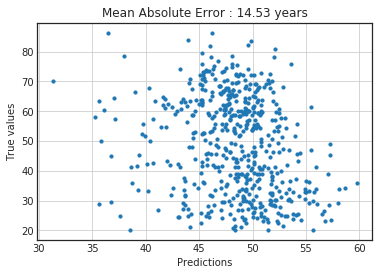

In [28]:
predict = model(Variable(torch.from_numpy(X)))
predict = predict.data.numpy()
labels = np.asarray(labels)
# Plot the results and compute the MAE
plt.scatter(predict, labels, s=10)
plt.grid()
plt.xlabel('Predictions')
plt.ylabel('True values')
mae = np.mean(np.abs(predict - labels))
plt.title('Mean Absolute Error : {:.2f} years'.format(mae))
plt.show()